### Sample program for LSTM  
https://www.kaggle.com/andreazzini/international-airline-passengers

#### Import libraries  

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

#### Parameters  

In [16]:
np.random.seed(11)
tf.random.set_seed(11)

# To show more rows and columns without "..."
pd.options.display.max_columns=999
pd.options.display.max_rows=999

#### Read CSV file  

In [17]:
# read data
df = pd.read_csv('tokyo-weather-2003-2012-utf8.csv',
                 delimiter=',',skiprows=6, header=None,
                 skipfooter=3, engine='python')
df.columns=['month', 'x1', 'x2', 'x3', 'x4']
print(df.shape)
print(df.info())
display(df.head())
display(df.tail())

(117, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   117 non-null    object 
 1   x1      117 non-null    float64
 2   x2      117 non-null    float64
 3   x3      117 non-null    int64  
 4   x4      117 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 4.7+ KB
None


,month,x1,x2,x3,x4
0,2003-1,9.3,101.0,46,0
1,2003-2,9.9,53.5,52,0
2,2003-3,12.7,159.5,49,0
3,2003-4,19.2,121.0,61,3
4,2003-5,22.4,172.5,65,7


,month,x1,x2,x3,x4
112,2012-5,23.6,231.0,65,12
113,2012-6,24.8,185.0,73,15
114,2012-7,30.1,130.0,75,27
115,2012-8,33.1,25.0,69,31
116,2012-9,29.8,214.5,73,27


#### Convert datatype of Month column to 'datetime'  

In [18]:
df['month'] = pd.to_datetime(df['month'])
# df['passengers(k)'] = df['passengers(k)'].astype('float')
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   month   117 non-null    datetime64[ns]
 1   x1      117 non-null    float64       
 2   x2      117 non-null    float64       
 3   x3      117 non-null    int64         
 4   x4      117 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 4.7 KB
None


,month,x1,x2,x3,x4
0,2003-01-01,9.3,101.0,46,0
1,2003-02-01,9.9,53.5,52,0
2,2003-03-01,12.7,159.5,49,0
3,2003-04-01,19.2,121.0,61,3
4,2003-05-01,22.4,172.5,65,7


#### Time series plot  

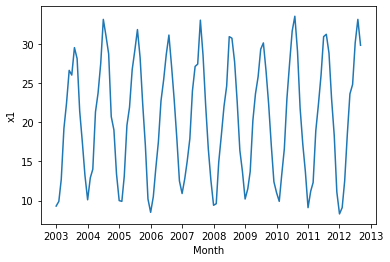

In [19]:
plt.plot(df['month'], df['x1'])
plt.xlabel('Month')
plt.ylabel('x1')
plt.show()

#### Set parameters for training / prediction  

In [20]:
w = 24
n_test = 12

In [21]:
passengers = df['x1']
print(passengers.shape)
print(passengers.head())

(117,)
0     9.3
1     9.9
2    12.7
3    19.2
4    22.4
Name: x1, dtype: float64


#### Standardization of training data  

In [22]:
xmin = np.amin(passengers[:-n_test])
xmax = np.amax(passengers[:-n_test])
scale = xmax-xmin
passengers = (passengers-xmin)/scale

#### Prepare for windows of training / test data  

In [23]:
x = []
y = []
n_months = passengers.shape[0]
for i in range(0, n_months-w-n_test):
    x.append(passengers[i:i+w])
    y.append(passengers[i+w])
x = np.array(x)
y = np.array(y)
print(x[:3])  # debug
print(y[:3])  # debug

[[0.032 0.056 0.168 0.428 0.556 0.724 0.7   0.84  0.784 0.516 0.356 0.188
  0.064 0.176 0.22  0.512 0.608 0.76  0.984 0.9   0.808 0.488 0.42  0.196]
 [0.056 0.168 0.428 0.556 0.724 0.7   0.84  0.784 0.516 0.356 0.188 0.064
  0.176 0.22  0.512 0.608 0.76  0.984 0.9   0.808 0.488 0.42  0.196 0.06 ]
 [0.168 0.428 0.556 0.724 0.7   0.84  0.784 0.516 0.356 0.188 0.064 0.176
  0.22  0.512 0.608 0.76  0.984 0.9   0.808 0.488 0.42  0.196 0.06  0.056]]
[0.06  0.056 0.184]


#### Reshape to fit the input of LSTM  

In [24]:
x = x.reshape(-1, w, 1)
y = y.reshape(-1, 1)
print(x.shape)
print(y.shape)
print(x)

(81, 24, 1)
(81, 1)
[[[0.032]
  [0.056]
  [0.168]
  ...
  [0.488]
  [0.42 ]
  [0.196]]

 [[0.056]
  [0.168]
  [0.428]
  ...
  [0.42 ]
  [0.196]
  [0.06 ]]

 [[0.168]
  [0.428]
  [0.556]
  ...
  [0.196]
  [0.06 ]
  [0.056]]

 ...

 [[0.832]
  [0.864]
  [0.72 ]
  ...
  [0.416]
  [0.548]
  [0.7  ]]

 [[0.864]
  [0.72 ]
  [0.552]
  ...
  [0.548]
  [0.7  ]
  [0.896]]

 [[0.72 ]
  [0.552]
  [0.34 ]
  ...
  [0.7  ]
  [0.896]
  [0.908]]]


#### Model building  

In [25]:
n_out = 1
n_hidden = 100

# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss',
                      patience=30, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(w, 1), return_sequences=False))
model.add(Dense(n_out, activation='linear'))

model.summary()

2021-10-09 16:06:54.100009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-09 16:06:54.100171: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-09 16:06:54.100203: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anhvu): /proc/driver/nvidia/version does not exist
2021-10-09 16:06:54.100563: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss="mean_squared_error", optimizer='adam')

#### Training  

In [27]:
%%time

# Learning 
n_epochs = 500
#n_epochs = 10
val_split = 0.2
batch_size = 1

fit_log = model.fit(x, y, batch_size=batch_size, epochs=n_epochs,
                    validation_split=val_split, callbacks=[es_cb])
#fit_log = model.fit(x, y, batch_size=batch_size, epochs=n_epochs,
#                    validation_split=val_split)

Epoch 1/500


2021-10-09 16:06:54.391214: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


64/64 [==============================] - 2s 11ms/step - loss: 0.1186 - val_loss: 0.1604
Epoch 2/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0832 - val_loss: 0.0862
Epoch 3/500
64/64 [==============================] - 0s 4ms/step - loss: 0.0419 - val_loss: 0.0046
Epoch 4/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.0091
Epoch 5/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 6/500
64/64 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 7/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0133
Epoch 8/500
64/64 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 9/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 10/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0097
Epoch 11/500
64/64 [

#### Do prediction  

In [28]:
# Against training data
pred = model.predict(x)
print(pred.shape)  # debug

(81, 1)


In [29]:
# Future prediction
future_test = passengers[n_months-w-n_test:n_months-n_test]
future_test = future_test.values.reshape(future_test.shape[0],1)
print(future_test.shape)
print(future_test)  # debug

(24, 1)
[[0.552]
 [0.34 ]
 [0.156]
 [0.1  ]
 [0.056]
 [0.188]
 [0.324]
 [0.58 ]
 [0.76 ]
 [0.924]
 [1.   ]
 [0.82 ]
 [0.532]
 [0.348]
 [0.208]
 [0.024]
 [0.108]
 [0.152]
 [0.416]
 [0.548]
 [0.7  ]
 [0.896]
 [0.908]
 [0.812]]


In [30]:
future_result = []

for i in range(n_test):
    test_data = np.reshape(future_test, (1, w, 1))
    #print(test_data.shape)  # debug
    pred1 = model.predict(test_data)
    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, pred1)
    future_result = np.append(future_result, pred1)

#### Generalization performance  

In [31]:
mse = mean_squared_error(passengers[-n_test:], future_result)
print('mse=', mse)

mse= 0.008454960281578133


#### Plot of the results   

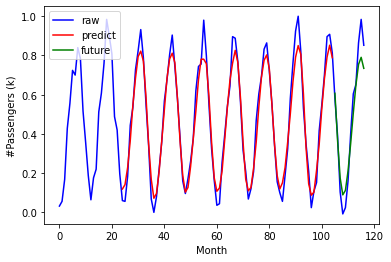

In [32]:
# Plot Wave    
n_pass = len(passengers)
n_pred = len(pred)
n_future = len(future_result)
plt.plot(range(0,n_pass), passengers, color="b", label="raw")
plt.plot(range(w,w+n_pred), pred, color="r", label="predict")  
plt.plot(range(n_pass-n_test,n_pass-n_test+n_future), future_result,
         color="g", label="future") 
plt.xlabel('Month')
plt.ylabel('#Passengers (k)')
plt.legend()
plt.show()

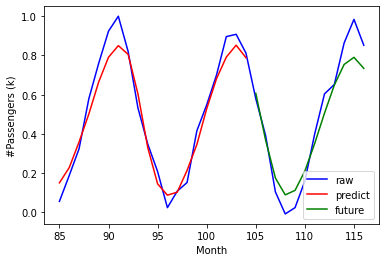

In [33]:
# Plot Wave
margin = 20
n_pass = len(passengers)
n_pred = len(pred)
plt.plot(range(n_pass-n_test-margin,n_pass), passengers[-n_test-margin:],
         color="b", label="raw")
plt.plot(range(w+n_pred-margin,w+n_pred), pred[-margin:], color="r", label="predict")  
plt.plot(range(n_pass-n_test,n_pass), future_result,
         color="g", label="future") 
plt.xlabel('Month')
plt.ylabel('#Passengers (k)')
plt.legend()
plt.show()

#### Plot of the log during the training  

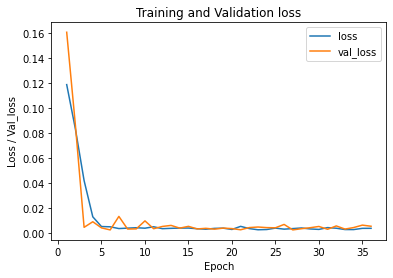

In [34]:
# Plot Training loss & Validation Loss
loss = fit_log.history["loss"]
val_loss = fit_log.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="loss" )
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Training and Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss / Val_loss')
plt.legend()
plt.show()